# Reinforcement Learning in Finite MDPs

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

## MDPs

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from cliffwalk import CliffWalk
from test_env import ToyEnv1

Setting up the environment

In [0]:
env = CliffWalk(proba_succ=0.98)

####################################################################################
# You probably want to test smaller enviroments before
#env = ToyEnv1(gamma=0.99)
####################################################################################

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")
print(env.R.shape)

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [0 3 2 2 1 0 0 1 0 0 2 2 1 3 2 2 1 1 1 1 3 1 3 3 1 3 1 2 3 3 3 0 3 1 0 0 1
 1 1 0 0 1 1 2 2 2 0 3]
(s, a, s', r):
36 1 36 0.6
36 1 36 0.6
36 1 36 0.6
36 1 36 0.6

(48, 4, 48)


## Question 1: Value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$

The function should return $Q_1$ such that :
$$Q_1(s,a) =\sum_{s'} p(s'|s,a)(r(s,a,s') + \gamma \max_a Q_0(s,a))$$

In [0]:
# --------------
# Point 1
# --------------
def bellman_operator(Q0, Ns, Na, R, P, gamma):
    # p*r part
    reward = np.sum(env.R * env.P,axis=2)

    # p*max_a(Q) part
    future_reward= np.zeros((Ns,Na))
    for s in range(Ns):
        for a in range(Na):
            for next_s in range(Ns):
                future_reward[s,a]+=P[s,a,next_s]*np.max(Q0[next_s])
                
    Q1=reward + gamma * future_reward
    #the greedy policy is the policy giving the best reward
    greedy_policy=np.argmax(Q1,axis=1)
    
    return Q1, greedy_policy

2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)

We use a stopping condition of the $\infty$-norm applied to the difference in $Q$ between two consecutive steps (since we are not supposed to know $Q^*$ in advance) :
$$ \| Q_{n+1} - Q_{n}  \|_{\infty} = \max_{s,a} |Q_{n+1}(s,a) - Q_n(s,a)|$$

In [0]:
# --------------
# Point 2
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    condition=1
    Q=Q0
    Q_history=[Q]

    # We iterate unitl the condition is met
    while condition>=epsilon:
        Q1,_=bellman_operator(Q,env.Ns,env.Na,env.R,env.P,env.gamma)
        Q_history.append(Q)
        condition = np.max(abs(Q1-Q)) #we stop when two succesive Q are close w.r.t the infinity-norm
        Q=Q1

    greedy_policy=np.argmax(Q,axis=1)
    
    return Q, greedy_policy, Q_history

3. Evaluate the convergence of your estimate, i.e., plot the value $\|Q_n - Q^\star\|_{\infty} = \max_{s,a} |Q_n(s,a) - Q^\star(s,a)|$

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

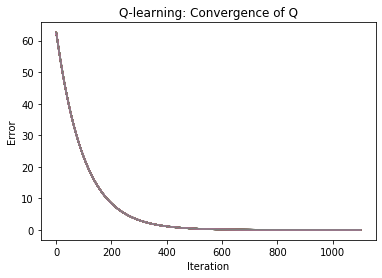

In [0]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]

# We initialize with an array of zeros with the same shape as the other Qs
Q_init=np.zeros(np.array(Qstar).shape)

Q, greedy_policy, Q_history = value_iteration(Q_init,env)

# Values of max_s,a |Q_n(s,a) - Qstar(s,a)| evolving with the iterations
norm_values=np.max(abs(Q_history-np.array(Qstar)),axis=2)

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

#### Observing the evolution of the states in the environment

In [0]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+---------------

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the sum of rewards as a function of iteration


$\epsilon$-greedy policy:
$$
\pi(s) = \begin{cases}
\max_a Q(s,a) & \text{w.p.} \epsilon\\
\text{random action} & \text{w.p.} 1- \epsilon
\end{cases}
$$

#### Defining the Learner

**\_\_init\_\_** initializes :
- the first $Q$ table, passed as argument,
- the environment, passed as argument,
- the $\epsilon$ used for the exploration passed as arguments,
- a table counting the number of visits for each state/action $(s,a)$, that will be used to compute a learning rate $\alpha$ each time we update $Q$.

**sample_action** : generates an action following the $\epsilon$-greedy policy.

**update** : updates $Q$ with the formula :
$$ Q[s,a] = (1-\alpha_t)Q[s,a] + \alpha_t(r_t + \gamma \max_a' Q[s',a']) $$

Where $r_t$ is the reward and $\alpha_t$ is the learning rate (defined as how much you accept the new value vs the old value) depending on $(s,a)$ by $\alpha_t = \frac{1}{\sqrt{N_t(s,a)}}$with $N_t$ the number of visits in $(s,a)$ at time $t$.

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------
# suggested interface
# you can change it!
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self,Q_init,env,epsilon):
        self.Q=Q_init # first value for Q
        self.env=env # environnement 
        self.epsilon=epsilon # epsilon for the epsilon-greedy exploration
        self.nb_visits=np.zeros((env.Ns, env.Na)) #store the nb of visits per (s,a)
        pass
    
    def sample_action(self,state):
        #choosing a random action following the epsilon-law
        random_action=np.random.uniform(0, 1)

        if random_action <= self.epsilon:
            next_action=np.argmax(self.Q[state,:])#greedy decision
        else:
            next_action=np.random.randint(0, self.env.Na )
        return next_action
    
    def update(self, state, action, next_state, reward):
        self.nb_visits[state,action]+=1 # update the nb of visits in the (s,a)

        alpha=1/np.sqrt(self.nb_visits[state,action]) # learning rate depending on (s,a)

        #updating Q
        delta=(reward + self.env.gamma * np.max(self.Q[next_state, :]) - self.Q[state, action])
       
        self.Q[state, action] = self.Q[state, action] + delta * alpha
        
        pass
    

#### Compute actual optimal values with previous code


In [0]:
# --------------
# Point 1
# --------------

Q0 = np.zeros((env.Ns, env.Na))
# Use the previous code to verify the correctness of q learning
Q_opt, pi_opt,_ = value_iteration(Q0, env, epsilon=1e-8)


#### Setting the number of steps

In [0]:
# Number of Q learning steps
max_steps = int(1e6)  
# max_steps = 10

### Main algorithmic loop

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : :_: : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
None
optimal policy:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]
est policy: [0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 3]


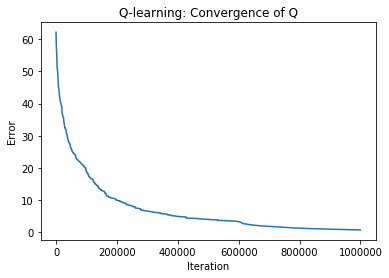

<function matplotlib.pyplot.axes>

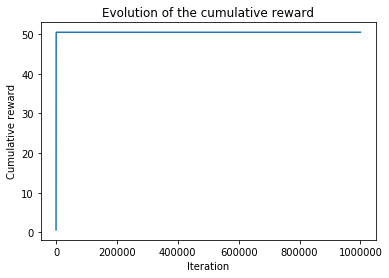

In [0]:
# Initialization
Q0 = np.zeros((env.Ns, env.Na))

ql=QLearning(Q0,env,epsilon=0.5)
norm_values = []
rewards = []

t = 0
state = env.reset()

# Loop until we reach the number of steps
while t < max_steps:
  
    action = ql.sample_action(state)# Choosing the action following the exploratory law

    observation, reward, done, info = env.step(action)# Take the action

    # Update the tables for the curves to plot
    norm_values.append(np.abs(ql.Q - Q_opt).mean())
    rewards.append(reward*(env.gamma**t))
    
    ql.update(state,action,observation,reward) # Update Q (t taken into account to update alpha)
    state = observation # Update the state

    t = t + 1
    
cum_rewards=np.cumsum(rewards)

print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy = np.argmax(ql.Q, axis=1)
print("est policy:", greedy_policy)


plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")
plt.show()

plt.plot(cum_rewards)
plt.xlabel('Iteration')
plt.ylabel('Cumulative reward')
plt.title("Evolution of the cumulative reward")
plt.axes

# how confident are you in the performance of the algorithm? maybe a single run is not enough

If we launch the algorithm several times with the same parameters, we obtain slightly different results each time that are not always equal to $Q_{opt}$ and $\pi_{opt}$.

However, they are always really good approximations, and, looking at the shape of the convergence curve, we might expect slightly better results when increasing the number of steps.
